In [31]:
# impor library
from matplotlib import pyplot as plt
import pandas as pd

In [32]:
# impor dataset
dataset = pd.read_csv('../integration-data/big-data.csv')

In [33]:
# cek dataset
dataset.head(10)

,jenisKelamin,umur,beratBadan,tinggiBadan
0,Female,12,7.1,65.0
1,Female,10,7.1,49.0
2,Male,11,8.0,72.2
3,Female,8,7.7,65.0
4,Male,13,9.0,92.7
5,Female,9,8.4,65.0
6,Male,14,8.5,69.0
7,Male,10,6.4,63.0
8,Female,9,9.0,72.2
9,L,19,7.0,90.0


In [34]:
dataset.max()

jenisKelamin        P
umur               60
beratBadan       15.0
tinggiBadan     100.2
dtype: object

In [35]:
# ubah nilai jenisKelamin
dataset.jenisKelamin = dataset.jenisKelamin.replace(['Male', 'L'], '0')
dataset.jenisKelamin = dataset.jenisKelamin.replace(['Female', 'P'], '1')
dataset.jenisKelamin = dataset.jenisKelamin.astype('int64')

In [36]:
# impor dataset who
who_haz = pd.read_csv('../raw-datasets/dataset-who-stunting.csv', delimiter=';', decimal=',')
who_whz = pd.read_csv('../raw-datasets/dataset-who-wasting.csv', delimiter=';', decimal=',')

In [37]:
# membuat kolom baru yaitu stunting dan wasting
dataset['z_stunting'] = 0.0
dataset['z_wasting'] = 0.0

In [38]:
# ubah gender pada tabel who untuk sama dengan di dataset
# who haz => height-for-age z-scores
who_haz.Gender = who_haz.Gender.replace('Male', '0')
who_haz.Gender = who_haz.Gender.replace('Female', '1')
# who wfh => weight-for-height z-scores
who_whz.Gender = who_whz.Gender.replace('Male', '0')
who_whz.Gender = who_whz.Gender.replace('Female', '1')
# ubah format gender menjadi nominal
who_haz.Gender = who_haz.Gender.astype('float64')
who_whz.Gender = who_whz.Gender.astype('float64')

In [39]:
# cari nilai unik yang tidak terdapat pada tabel whz
# nilai unik berupa nilai yang tidak bernilai multiplikasi 0.5
unique_height = dataset.loc[dataset.tinggiBadan % 0.5 != 0, ['jenisKelamin', 'tinggiBadan']]
unique_height = unique_height.rename(columns={'jenisKelamin':'Gender', 'tinggiBadan':'Length'})
unique_height = unique_height.drop_duplicates()
# gabung data unik kedalam data whz
who_whz = pd.concat([who_whz, unique_height])
# sortir data whz dari gender lalu tinggi
who_whz = who_whz.sort_values(['Gender', 'Length'], ignore_index=True)

In [40]:
# interpolasi nilai unik berdasar data whz
# proses interpolasi dibedakan gender
whz_0 = who_whz.loc[who_whz.Gender == 0].interpolate(method='linear', limit_area='inside')
whz_1 = who_whz.loc[who_whz.Gender == 1].interpolate(method='linear', limit_area='inside')
# gabung hasil interpolasi menjadi tabel whz baru
who_whz = pd.concat([whz_0, whz_1])
# sortir data whz menurut tinggi
who_whz = who_whz.sort_values(['Length', 'Gender'], ignore_index=True)

In [41]:
# cari nilai z-score stunting
# loop seluruh dataset
for stunting_cursor in dataset.itertuples():
    # loop untuk mencari data yang tepat di tabel haz
    for who_cursor in  who_haz.itertuples():
        # cek persamaan jenisKelamin
        if who_cursor.Gender == stunting_cursor.jenisKelamin:
            # cek persamaan umur
            if who_cursor.Month == stunting_cursor.umur:
                l_score = who_cursor.L
                m_score = who_cursor.M
                s_score = who_cursor.S
                # hitung nilai z-score
                z_score = (((stunting_cursor.tinggiBadan / m_score)**l_score) - 1) / (l_score * s_score)
                # masukkan nilai dalam kolom z_stunting
                dataset.loc[dataset.index == stunting_cursor.Index, 'z_stunting'] = round(z_score, 3)
                continue

In [42]:
# cari nilai z-score wasting
# loop seluruh dataset
for wasting_cursor in dataset.itertuples():
    # loop untuk mencari data yang tepat di tabel haz
    for who_cursor in  who_whz.itertuples():
        # cek persamaan jenisKelamin
        if who_cursor.Gender == wasting_cursor.jenisKelamin:
            # cek persamaan tinggi
            if who_cursor.Length == wasting_cursor.tinggiBadan:
                l_score = who_cursor.L
                m_score = who_cursor.M
                s_score = who_cursor.S
                # hitung nilai z-score
                z_score = (((wasting_cursor.beratBadan / m_score)**l_score) - 1) / (l_score * s_score)
                # masukkan nilai dalam kolom z_stunting
                dataset.loc[dataset.index == wasting_cursor.Index, 'z_wasting'] = round(z_score, 3)
                continue

In [43]:
# membuat kolom baru label yang mengindikasi status data
dataset['label'] = 0
# tentukan nilai label
# 0:sehat, 1:stunting, 2:wasting, 3:stunting&wasting
for status in dataset.itertuples():
    # cek sehat
    if status.z_stunting > -2.0 and status.z_wasting > -2.0:
        dataset.loc[dataset.index == status.Index, 'label'] = 0
    # cek stunting
    elif status.z_stunting <= -2.0:
        # cek stunting & wasting
        if status.z_wasting <= -2.0:
            dataset.loc[dataset.index == status.Index, 'label'] = 3
        # jika wasting gagal, otomatis stunting
        else:
            dataset.loc[dataset.index == status.Index, 'label'] = 1
    # jika stunting gagal dan sehat gagal, otomatis wasting
    else:
        dataset.loc[dataset.index == status.Index, 'label'] = 2

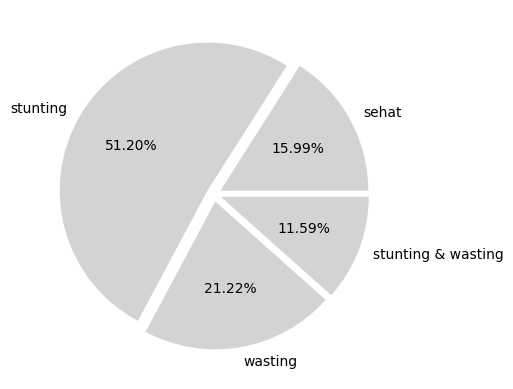

In [45]:
# hitung total persebaran
totalSehat = dataset.loc[dataset.label == 0, 'label'].count()
totalStunting = dataset.loc[dataset.label == 1, 'label'].count()
totalWasting = dataset.loc[dataset.label == 2, 'label'].count()
totalKeduanya = dataset.loc[dataset.label == 3, 'label'].count()

# beri label tiap data
labels = ['sehat', 'stunting', 'wasting', 'stunting & wasting']
# beri spasi antar data
explode = [0.05, 0.05, 0.05, 0.05]
# beri warna setiap data
colors = ['lightgray', 'lightgray', 'lightgray', 'lightgray']

# visualisasikan ke matplot piechart
fig, ax = plt.subplots()
ax = plt.pie([totalSehat, totalStunting, totalWasting, totalKeduanya], explode=explode, labels=labels, colors=colors, autopct='%.2f%%')
plt.show()

In [51]:
# impor library
from sklearn.model_selection import train_test_split as sk_split
# tetapkan fitur dan label
fitur = dataset.loc[:, ['jenisKelamin', 'umur', 'beratBadan', 'tinggiBadan']]
label = dataset.loc[:, ['label']]
# bagi dataset menjadi 2 data, latih dan uji
latih_fitur, uji_fitur, latih_target, uji_target = sk_split(fitur, label, test_size=0.20)

In [52]:
# menerapkan oversampling dengan SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=18062025)
latih_fitur_resample, latih_target_resample = sm.fit_resample(latih_fitur, latih_target)

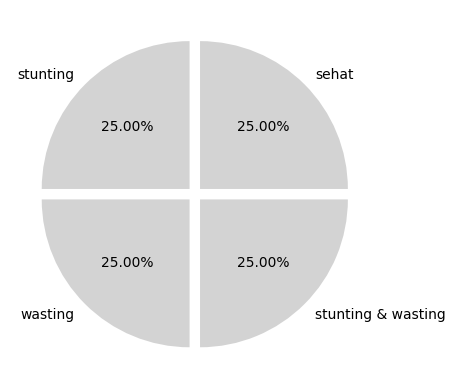

In [53]:
# hitung total persebaran
totalSehat = latih_target_resample.loc[latih_target_resample.label == 0, 'label'].count()
totalStunting = latih_target_resample.loc[latih_target_resample.label == 1, 'label'].count()
totalWasting = latih_target_resample.loc[latih_target_resample.label == 2, 'label'].count()
totalKeduanya = latih_target_resample.loc[latih_target_resample.label == 3, 'label'].count()

# beri label tiap data
labels = ['sehat', 'stunting', 'wasting', 'stunting & wasting']
# beri spasi antar data
explode = [0.05, 0.05, 0.05, 0.05]
# beri warna setiap data
colors = ['lightgray', 'lightgray', 'lightgray', 'lightgray']

# visualisasikan ke matplot piechart
fig, ax = plt.subplots()
ax = plt.pie([totalSehat, totalStunting, totalWasting, totalKeduanya], explode=explode, labels=labels, colors=colors, autopct='%.2f%%')
plt.show()

In [54]:
# gabung data fitur dan label pada kedua dataset
dataset_latih = pd.concat([latih_fitur_resample, latih_target_resample], axis=1)
dataset_uji = pd.concat([uji_fitur, uji_target], axis=1)

In [57]:
# ganti format umur menjadi float
dataset_latih.umur = dataset_latih.umur.astype('float64')
dataset_uji.umur = dataset_uji.umur.astype('float64')

In [58]:
# normalisasi dataset latih
umur_min = dataset_latih.umur.min()
umur_max = dataset_latih.umur.max()
tinggi_min = dataset_latih.tinggiBadan.min()
tinggi_max = dataset_latih.tinggiBadan.max()
berat_min = dataset_latih.beratBadan.min()
berat_max = dataset_latih.beratBadan.max()
for cursor_data in dataset_latih.itertuples():
    current_umur = dataset_latih.loc[dataset_latih.index == cursor_data.Index, 'umur']
    dataset_latih.loc[dataset_latih.index == cursor_data.Index, 'umur'] = (current_umur - umur_min) / (umur_max - umur_min)
    current_tinggi = dataset_latih.loc[dataset_latih.index == cursor_data.Index, 'tinggiBadan']
    dataset_latih.loc[dataset_latih.index == cursor_data.Index, 'tinggiBadan'] = (current_tinggi - tinggi_min) / (tinggi_max - tinggi_min)
    current_berat = dataset_latih.loc[dataset_latih.index == cursor_data.Index, 'beratBadan']
    dataset_latih.loc[dataset_latih.index == cursor_data.Index, 'beratBadan'] = (current_berat - berat_min) / (berat_max - berat_min)

In [59]:
# normalisasi dataset uji
umur_min = dataset_uji.umur.min()
umur_max = dataset_uji.umur.max()
tinggi_min = dataset_uji.tinggiBadan.min()
tinggi_max = dataset_uji.tinggiBadan.max()
berat_min = dataset_uji.beratBadan.min()
berat_max = dataset_uji.beratBadan.max()
for cursor_data in dataset_uji.itertuples():
    current_umur = dataset_uji.loc[dataset_uji.index == cursor_data.Index, 'umur']
    dataset_uji.loc[dataset_uji.index == cursor_data.Index, 'umur'] = (current_umur - umur_min) / (umur_max - umur_min)
    current_tinggi = dataset_uji.loc[dataset_uji.index == cursor_data.Index, 'tinggiBadan']
    dataset_uji.loc[dataset_uji.index == cursor_data.Index, 'tinggiBadan'] = (current_tinggi - tinggi_min) / (tinggi_max - tinggi_min)
    current_berat = dataset_uji.loc[dataset_uji.index == cursor_data.Index, 'beratBadan']
    dataset_uji.loc[dataset_uji.index == cursor_data.Index, 'beratBadan'] = (current_berat - berat_min) / (berat_max - berat_min)

In [61]:
# acak urutan dataset
dataset_latih = dataset_latih.sample(frac=1, random_state=18062025, ignore_index=True)
dataset_uji = dataset_uji.sample(frac=1, random_state=18062025, ignore_index=True)

In [62]:
# ekspor dataset
dataset_latih.to_csv('data_latih.csv', index=False)
dataset_uji.to_csv('data_uji.csv', index=False)